# Introduction to DEA Fractional Cover <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls_fc_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_fc_3), 
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_3)


## Background
Fractional cover data can be used to identify large scale patterns and trends and inform evidence based decision making and policy on topics including wind and water erosion risk, soil carbon dynamics, land management practices and rangeland condition.

This information is used by policy agencies, natural and agricultural land resource managers, and scientists to monitor land conditions over large areas over long time frames.

### What this product offers
[Fractional Cover (FC)](https://cmi.ga.gov.au/data-products/dea/119/dea-fractional-cover-landsat#basics), developed by the Joint Remote Sensing Research Program, is a measurement that splits the landscape into three parts, or fractions:

* green (leaves, grass, and growing crops)
* brown (branches, dry grass or hay, and dead leaf litter)
* bare ground (soil or rock)

DEA uses Fractional Cover to characterise every 30 m square of Australia for any point in time from 1987 to today.

### Applications
Fractional cover provides valuable information for a range of environmental and agricultural applications, including:

* soil erosion monitoring
* land surface process modelling
* land management practices (e.g. crop rotation, stubble management, rangeland management)
* vegetation studies
* fuel load estimation
* ecosystem modelling
* land cover mapping

> **Note:** For more technical information about DEA Fractional Cover, visit the official [Geoscience Australia DEA Fractional Cover product description](https://cmi.ga.gov.au/data-products/dea/119/dea-fractional-cover-landsat#basics).

## Description
This notebook will demonstrate how to load data from DEA Fractional Cover using the Digital Earth Australia datacube. 
Topics covered include:

1. Inspecting the products and measurements available in the datacube
2. Loading DEA Fractional Cover data for an inland location
3. Plotting fractional cover as false colour images
4. Inspecting unmixing error outputs
4. Masking out nodata and unclear or wet pixels, and using this to track percentages of green and brown vegetation and bare soil over time

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
import datacube
from datacube.storage import masking
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import plot_wo
from dea_datahandling import wofs_fuser


/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='DEA_Fractional_Cover')

## Available products and measurements

### List products available in Digital Earth Australia
We can use datacube's `list_products` functionality to inspect DEA Fractional Cover products that are available in the datacube.
The table below shows the product name that we will use to load the data and a brief description of the product.

In [3]:
# List DEA High and Low Tide Imagery products available in DEA
dc_products = dc.list_products()
display_columns = [
    'name', 'description', 'product_type', 'crs', 'resolution',
    'spatial_dimensions'
]
display(dc_products[dc_products.name == 'ga_ls_fc_3']
        [display_columns].set_index('name'))

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
ga_ls_fc_3,Geoscience Australia Landsat Fractional Cover ...,NaN,NaN,NaN,NaN


### List measurements
We can inspect the contents of the DEA Fractional Cover product using datacube's `list_measurements` functionality.
The table below lists each of the measurements available in the product, which represent unique data variables that provide information about the vegetation and bare soil cover in each pixel:

* `pv`: The fractional cover of green vegetation 
* `npv`:  The fractional cover of non-green vegetation
* `bs`: The fractional cover of bare soil 
* `ue`: The fractional cover unmixing error

The table also provides information about the measurement data types, units, nodata value and other technical information about each measurement.

In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['ga_ls_fc_3']

,name,dtype,units,nodata,aliases,flags_definition,spectral_definition
measurement,,,,,,,
bs,bs,uint8,percent,255,[bare],NaN,NaN
pv,pv,uint8,percent,255,[green_veg],NaN,NaN
npv,npv,uint8,percent,255,[dead_veg],NaN,NaN
ue,ue,uint8,1,255,[err],NaN,NaN


## Loading data
Now that we know what products and measurements are available for the products, we can load data from the datacube for an example location:

In [5]:
# Set up a region to load data
query = {
    'x': (140.18, 140.35),
    'y': (-35.90, -36.05),
    'time': ('1995-09-01', '1995-12-15'),
}

# Load DEA Fractional Cover data from the datacube
fc = dc.load(product='ga_ls_fc_3',
             measurements=['bs', 'pv', 'npv', 'ue'],
             output_crs='EPSG:32754',
             resolution=(-30, 30),
             group_by='solar_day',
             **query)

We can now view the data that we loaded.
The measurements listed under `Data variables` should match the measurements displayed in the previous [List measurements](#List-measurements) step.

In [6]:
fc

<xarray.Dataset>
Dimensions:      (time: 4, x: 516, y: 560)
Coordinates:
  * time         (time) datetime64[ns] 1995-09-02T23:30:20.277301 ... 1995-12...
  * y            (y) float64 6.027e+06 6.027e+06 6.027e+06 ... 6.01e+06 6.01e+06
  * x            (x) float64 4.26e+05 4.26e+05 4.261e+05 ... 4.414e+05 4.415e+05
    spatial_ref  int32 32754
Data variables:
    bs           (time, y, x) uint8 9 21 23 12 20 23 24 22 ... 19 11 8 9 12 8 16
    pv           (time, y, x) uint8 66 62 58 65 67 67 66 ... 22 20 19 18 17 18
    npv          (time, y, x) uint8 23 15 18 21 11 9 8 ... 63 66 70 71 68 73 64
    ue           (time, y, x) uint8 12 11 11 12 11 11 10 10 ... 9 9 8 7 7 7 7 7
Attributes:
    crs:           EPSG:32754
    grid_mapping:  spatial_ref

## Plotting data <img align="right" src="../Supplementary_data/DEA_Fractional_Cover/fc_legend.jpg" alt="Fractional cover ternary diagram">

We can plot each fractional cover variable in our dataset (i.e. `['bs', 'pv', 'npv']`) using the `rgb` function. 
This will create a false colour view of the data where shades of green, blue and red represent varying proportions of vegetation and bare soil cover:
* Green: green vegetation (`pv`)
* Blue: brown (i.e. 'non-green') vegetation (`npv`)
* Red: bare soil (`bs`)

In the images below, you can see growing vegetation (green) transitioning into brown vegetation (blue) and bare soil (red) over time:

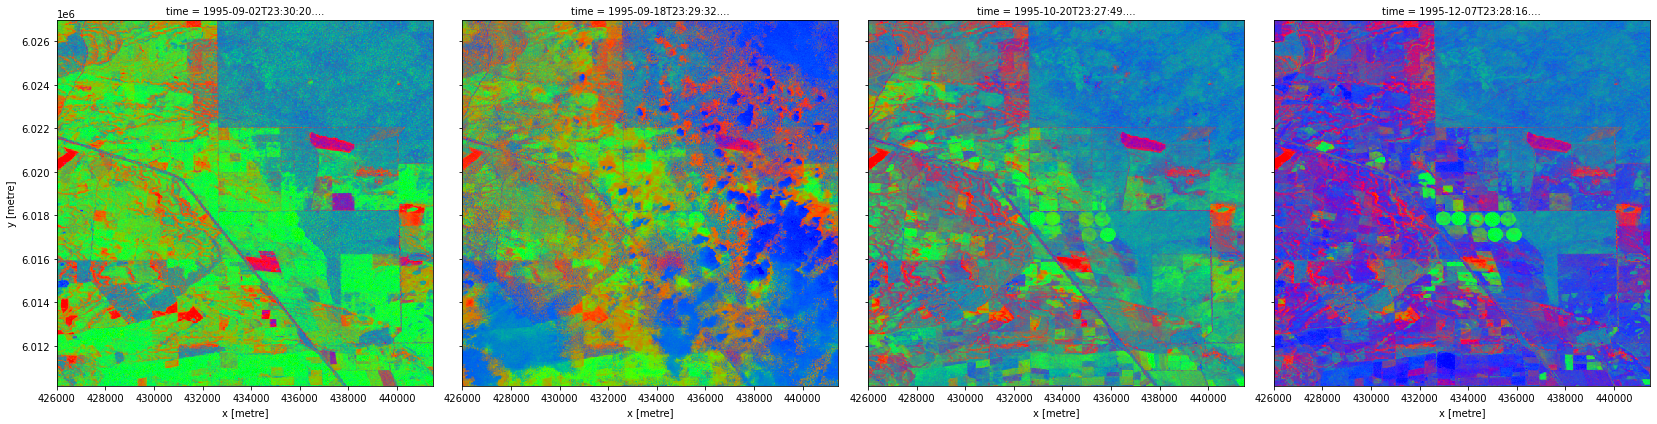

In [7]:
# Plot DEA Fractional Cover data as a false colour RGB image
rgb(fc, bands=['bs', 'pv', 'npv'], col='time')


We can also visualises the 'unmixing error' (`ue`) for each of our DEA Fractional Cover observations. High unmixing error values (bright colours below) represent areas of higher model uncertainty (e.g. areas of water, cloud, cloud shadow or soil types/colours that were not included in the model training data). This data can be useful for removing uncertain pixels from an analysis.

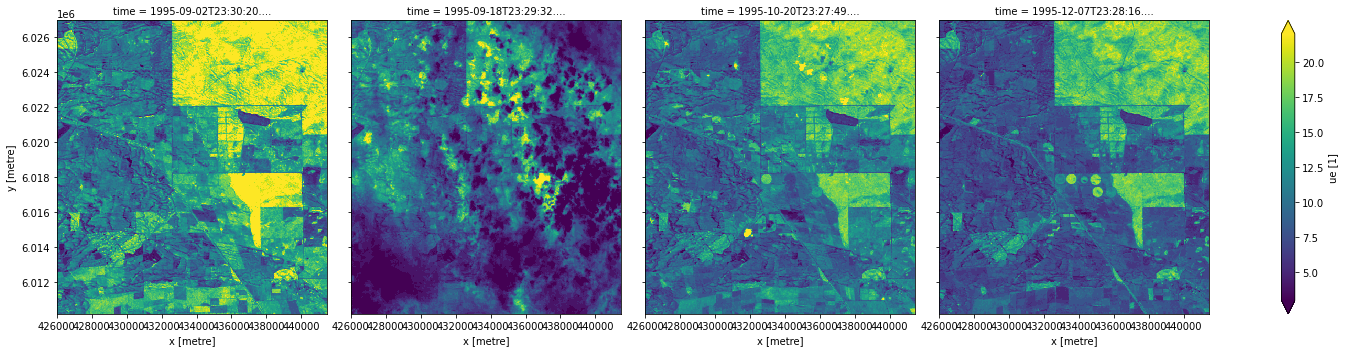

In [8]:
fc.ue.plot(col='time', robust=True, size=5)

> **Note:** For more information about plotting data, refer to the [Introduction to Plotting notebook](../Beginners_guide/05_Plotting.ipynb).

## Example application: tracking changes in vegetation cover and bare soil over time



### Setting nodata
As the first step in our analysis, we need to set nodata pixels to `NaN`. This ensures that missing data is dealt with correctly in any future calculations.

In [9]:
# Replace all nodata values with `NaN`
fc = masking.mask_invalid_data(fc)

### Applying a cloud and water mask
In the images we plotted earlier, you may have noticed the second panel is affected by cloud. This can cause the fractional cover algorithm to produce misleading results. 
Fractional cover will also produce poor results over water. To track fractional cover reliably over time, we need to remove potentially inaccurate pixels from our data. One of the easiest ways to do this is to load data from the DEA Water Observations product that identifies wet and unclear pixels (e.g. cloud or cloud shadow) in the landscape.

In the next cell, we load DEA Water Observations data into the extents of our DEA Fractional Cover data using the `like` argument (for more details about this, see the [introduction to loading data](../Beginners_guide/04_Loading_data.ipynb)).

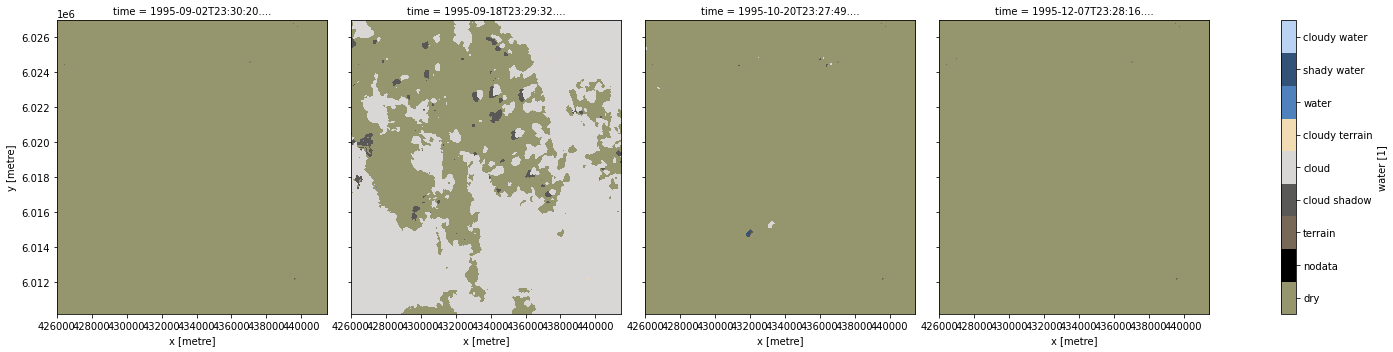

In [10]:
# Load DEA Water Observations data from the datacube
wo = dc.load(product='ga_ls_wo_3',
             group_by='solar_day',
             fuse_func=wofs_fuser,
             like=fc)

# Plot the loaded water observations
plot_wo(wo.water, col='time', size=5)

The previous plot showed that the second and third images in our data contain cloud and cloud shadow. To remove this pixels from our data, we first create a binary mask where `True` (yellow) represents clear and dry pixels, and `False` (purple) represents wet, cloudy or shadowy pixels.

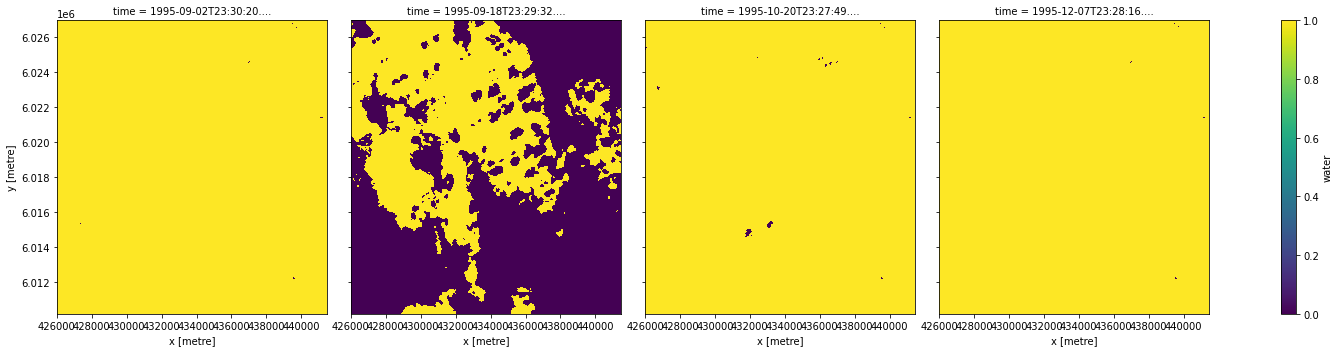

In [11]:
# Keeping dry, non-cloudy pixels
wo_mask = masking.make_mask(wo.water, dry=True)
wo_mask.plot(col='time', size=5)

Using this mask, we can now remove wet and unclear pixels from our original DEA Fractional Cover data. Note that these pixels now appear white, representing `nodata`.

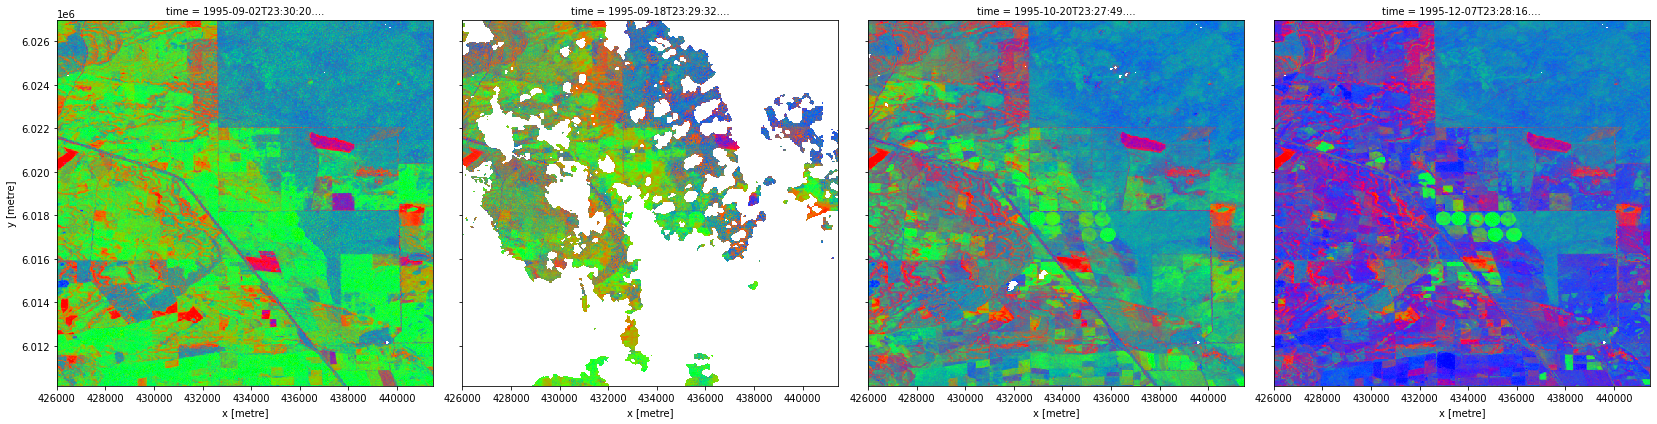

In [12]:
fc_masked = fc.where(wo_mask)
rgb(fc_masked, bands=['bs', 'pv', 'npv'], col='time')

### Calculating average fractional cover over time
Now that our fractional cover data has had nodata values and cloud, shadow and water pixels set to `NaN`, we can reliably calculate statistics to track how proportions of green and brown vegetation and bare soil have changed over time. We can then plot this as a simple line chart:

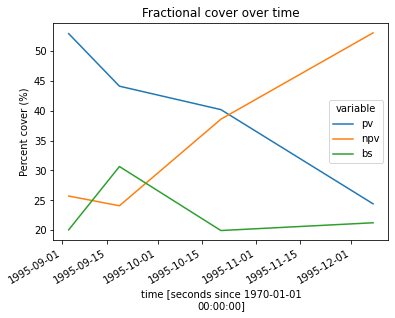

In [13]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time
fc_through_time = fc_masked[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
fc_through_time.to_array().plot.line(hue='variable')
plt.title('Fractional cover over time')
plt.ylabel('Percent cover (%)');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2021

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.4.dev193+g3997b90f


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)